In [3]:
import sys
import os

src_path = os.path.abspath(os.path.join('..', 'src'))
if src_path not in sys.path:
    sys.path.append(src_path)

In [4]:
import warnings
from sklearn.metrics import accuracy_score

from preprocess import load_dataset, preprocess_dataset
from model import MLPClassifier, predict_nn, train_nn_adversarial
from causal_analysis import estimate_causal_effect, creat_causal_model
from fairness_metrics import compute_fairness_metrics
from visualization import plot_repair_effect

# Ignore warnings to keep the output clean
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Define file path and relevant columns
file_path = '../data/adult.csv'
relevant_columns = [
    'age', 'workclass', 'fnlwgt', 'education.num', 'marital.status',
    'occupation', 'relationship', 'race', 'sex', 'capital.gain',
    'capital.loss', 'hours.per.week', 'native.country', 'income'
]
target_column = 'income'

# Load and preprocess data
data = load_dataset(file_path)
# Convert income to a binary variable (0 or 1)
data['income'] = (data['income'] == '>50K').astype(int)

# Preprocess the dataset and split into train and test sets
(X_train, X_test, y_train, y_test), processed_data = preprocess_dataset(
    data, relevant_cols=relevant_columns, target_column=target_column
)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")


Dataset loaded successfully from ../data/adult.csv.
Selected relevant columns and dropped missing values.
Encoded categorical variables using one-hot encoding.
Replaced spaces and hyphens with underscores in column names.
Split data into features (X) and target (y): income.
Data split into train and test sets with test size = 0.3.
Training Data Shape: (22792, 85)
Testing Data Shape: (9769, 85)



=== BEFORE REPAIR ===
Mean Income for Females: 0.1088
Mean Income for Males: 0.3055
Demographic Parity Difference: 0.1967
Correlation (Sensitive vs Income): 0.2162


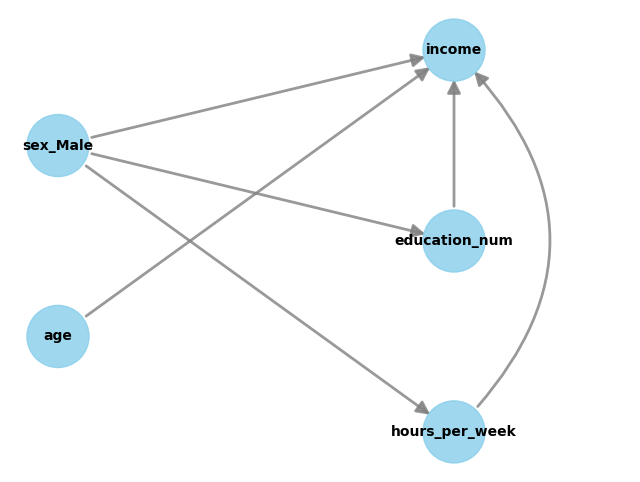


=== Causal Effect BEFORE Repair ===
Estimated Total Effect of Gender on Income: 0.1894


In [6]:
# Fairness Metrics Before Repair
compute_fairness_metrics(X_test, y_test, title="BEFORE REPAIR")

# Define the causal graph in DOT format
causal_graph = """
digraph {
    sex_Male -> income;
    sex_Male -> education_num;
    education_num -> income;
    hours_per_week -> income;
    sex_Male -> hours_per_week;
    age -> income;
}
"""

# Prepare data for causal analysis (select test rows from processed_data)
processed_data_test = processed_data.loc[X_test.index, :].copy()

# Create the causal model using the provided graph, sensitive attribute, and outcome
causal_model = creat_causal_model(processed_data_test, causal_graph, "sex_Male", "income")
causal_model.view_model()  # This should display the causal graph

# Estimate the causal effect before repair
effect_before = estimate_causal_effect(causal_model)
print(f"\n=== Causal Effect BEFORE Repair ===")
print(f"Estimated Total Effect of Gender on Income: {effect_before.value:.4f}")


In [7]:
# Define feature columns to be used in the model
feature_cols = ['education_num', 'hours_per_week', 'age']

# Assume 'sex_Male' is stored in X_train (adjust if necessary)
s_train = X_train['sex_Male']

# Train the neural network model
model_nn, scaler = train_nn_adversarial(X_train, y_train, s_train, feature_cols, n_epochs=500, lambda_=10)

# Predict on the test set
y_pred = predict_nn(model_nn, X_test, feature_cols, scaler)
print(f"\nTest Accuracy (NN): {accuracy_score(y_test, y_pred):.4f}")


Adversarial Training...: 100%|██████████| 500/500 [00:09<00:00, 51.89it/s]

======= Training Completed ========
Adversary accuracy: 0.704

Test Accuracy (NN): 0.7991



=== AFTER REPAIR ===
Mean Income for Females: 0.0958
Mean Income for Males: 0.1778
Demographic Parity Difference: 0.0820
Correlation (Sensitive vs Income): 0.1077

=== Causal Effect AFTER Repair ===
Estimated Total Effect of Gender on Income: 0.0752


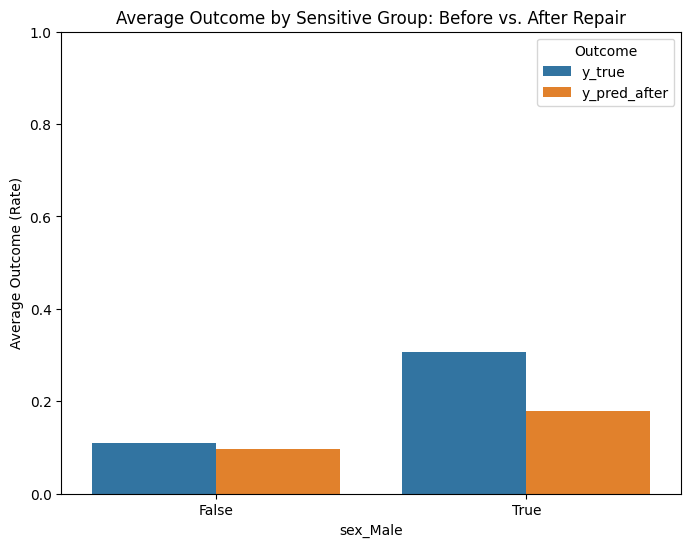

In [8]:
# Optionally, if you have a counterfactual repair function, you might generate counterfactual predictions here
# For example:
# df_results = generate_counterfactuals(X_test, model_nn, scaler, feature_cols, y_test)

# Fairness Metrics After Repair
compute_fairness_metrics(X_test, y_pred.squeeze(), title="AFTER REPAIR")

# Update the processed test data with the new predicted income values
processed_data_test["income"] = y_pred

# Create a new causal model with the repaired/predicted outcome
causal_model_after = creat_causal_model(processed_data_test, causal_graph, "sex_Male", "income")
effect_after = estimate_causal_effect(causal_model_after)
print(f"\n=== Causal Effect AFTER Repair ===")
print(f"Estimated Total Effect of Gender on Income: {effect_after.value:.4f}")

# Visualize the repair effect
plot_repair_effect(X_test, y_test, y_pred.squeeze())
